In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
import torch
from torchvision import transforms
import math
from tqdm import tqdm

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

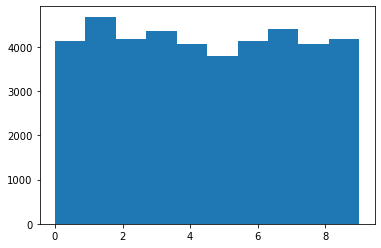

In [4]:
#Plot a histogram of the different hand written didgets

plt.hist(train.iloc[:, 0])

In [5]:
mean = train.mean()
std =  train.std()

In [6]:
classes = np.sort(train.iloc[:, 0].unique())
print(classes)

[0 1 2 3 4 5 6 7 8 9]


In [7]:
#This function will get the image and turn it into a tensor and return the tensor and data label of a given 
# row
def get_image(data = train, row = 0):
    image = train.iloc[row,1:]
    label = train.iloc[row, 0]
    image = torch.tensor(image).view(28,28)
    return image, label


def to_tensor(data = train, row = 0):
    image = train.iloc[row,1:]
    image = torch.tensor(image).type(torch.float).view(1,1,28,28)
    return image

#This function takes a tensor input and the data label and prints the image
def show_image(image, label):
    #img = np.moveaxis(image,0, -1)
    print("The image is:", label)
    
    plt.imshow(image)
    plt.show()
    

The image is: 8


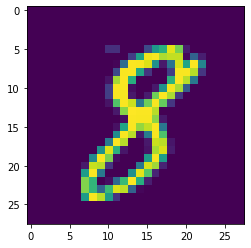

In [8]:
image, label = get_image(row = 20)
show_image(image, label)
#print(image)

In [9]:
#Network Time

#A new neural network set up for cool guys (or girls)
class cgNet(nn.Module):
   
    def __init__(self):
        super(cgNet, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)

        
        self.pool = nn.MaxPool2d(2,2)
    
        self.fc1 = nn.Linear(14*14*64, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = nn.ReplicationPad2d(1)(x)
        x = self.pool(F.relu(self.conv1(x)))
        
        x = nn.ReplicationPad2d(1)(x)
        
        x = F.relu(self.conv2(x))
        
        #print(x.shape)
        x = x.view(-1, 14*14*64)
        #print(x.shape)
        #x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()
        num_features = 1
        for s in size:
            num_features *= s
        #print(num_features)
        return num_features
        

In [10]:
#Manual pass through network to see that it works and output type
network = cgNet()

#initialize some weights
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

network.apply(init_weights)

image = to_tensor(train, 20)
out = network(torch.Tensor(image))
print(out)

tensor([[-1.8896,  9.3230,  5.1831,  4.8245, -6.6394, -0.6137,  7.3387,  4.3499,
         -5.7137,  7.5691]], grad_fn=<AddmmBackward>)


In [11]:
import torch.optim as optim


optimizer = optim.Adam(network.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

train_X = torch.Tensor(train.iloc[:, 1:].values).view(-1, 28, 28).cuda()
trainList = []
for i in train.iloc[:, 0].values:
    trainList.append(np.eye(10)[i])

train_Y = torch.tensor(trainList).float().cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device {device}")

network = network.to(device)
train_Y.shape

Using device cuda


torch.Size([42000, 10])

In [12]:
BATCH_SIZE = 32
EPOCHS = 5
loss_values = []
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train), BATCH_SIZE)):
        #batch_x = torch.Tensor(train.iloc[i:i + BATCH_SIZE, 1:].values).view(-1,1, 28, 28)
        #batch_y = torch.Tensor(train.iloc[i: i + BATCH_SIZE, 0].values).view(-1, 1, 1, 1)
        batch_x = train_X[i: i+BATCH_SIZE].view(-1, 1, 28, 28)
        batch_y = train_Y[i: i+BATCH_SIZE]
        
        network.zero_grad()
        
        outputs = network(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
    loss_values.append((epoch, loss))  
    print(f"Epoch: {epoch}. Loss: {loss}")

  1%|          | 12/1313 [00:00<00:12, 101.24it/s]

Epoch: 0. Loss: 0.018511805683374405


  1%|          | 12/1313 [00:00<00:12, 103.69it/s]

Epoch: 1. Loss: 0.00989245530217886


  1%|          | 12/1313 [00:00<00:13, 98.66it/s]

Epoch: 2. Loss: 0.004828334785997868


  1%|          | 11/1313 [00:00<00:11, 109.13it/s]

Epoch: 3. Loss: 0.0031123498920351267


100%|██████████| 1313/1313 [00:28<00:00, 46.44it/s]


Epoch: 4. Loss: 0.002625482389703393


In [13]:
test_X = torch.Tensor(train.iloc[:, 1:].values).view(-1, 28, 28).cuda()
testList = []
for i in train.iloc[:, 0].values:
    testList.append(np.eye(10)[i])

test_Y = torch.tensor(testList).float().cuda()

In [14]:
correct = 0
total = 0
count = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_Y[i])
        net_out = network(test_X[i].view(-1, 1, 28, 28))[0]
        predicted_class = torch.argmax(net_out)
 
        #value = (predicted_class == real_class)
        #print(predicted_class)
        #print(real_class)
        #print(value.item())
        #break
    
        if predicted_class == real_class:
            correct += 1
        total += 1

print("Accuracy: ", round(correct/total, 4))

100%|██████████| 42000/42000 [00:24<00:00, 1706.36it/s]

Accuracy:  0.9911


In [15]:
x, y = [], []
for i in loss_values:
    x.append(i[0])
    y.append(i[1].item())

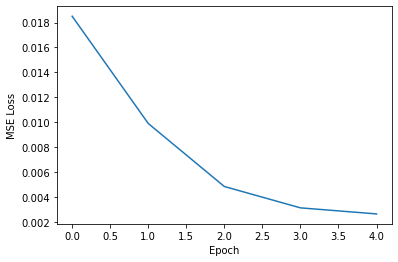

In [16]:
plt.plot(x,y)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()